# Smart E-commerce Catalog Data Analysis
##6. Logistic Regression Analysis on E-commerce Data

##1. Importing the dataset

In [0]:
#import the dataset

import pandas as pd 
data_prepared = spark.sql("SELECT * FROM product_db.products_data_prepared")
prepared_df = data_prepared.toPandas()


In [0]:
prepared_df.dropna(inplace=True)

###2. Defining Dependent and Independent Variables

**Dependent Variable (Target):**

The dependent variable will be `in_demand`.

 Independent Variables (Features) will be:
- `category_Clothing`, `category_Electronics`, `category_Home`, `category_Toys`: These one-hot encoded category variables allow the model to capture distinct demand patterns across different product types, enabling more accurate predictions.

- `rating_category_Medium`, `rating_category_High`: These features categorize ratings into bins, helping the model understand how higher ratings influence demand, which may not be linear.

- `price`: This continuous variable provides critical information on how pricing affects demand, allowing the model to assess the relationship between price and the likelihood of being "in demand."

###3. Isolating the variables


In [0]:
prepared_df.head(2)

,product_id,product_name,price,stock,rating,launch_date,description,is_active,in_demand,category_Clothing,category_Electronics,category_Home,category_Toys,rating_category_Medium,rating_category_High,rating_category_Very_High
0,744,Product 744,420.850006,17,3.7,2024-05-14,This is a great product.,False,1,0,0,1,0,0,1,0
1,745,Product 745,225.449997,99,2.2,2024-01-22,This is a great product.,True,0,0,0,0,0,1,0,0


In [0]:
# Define the dependent variable
y = prepared_df['in_demand']

# Define the independent variables (X)
X = prepared_df.drop(columns=['product_id','product_name', 'launch_date', 'description', 'is_active', 'in_demand','stock'] )


###4. Check Logistic Regression Assumptions

**Logistic regression has several assumptions that I should verify:**

- Binary Dependent Variable: `True`

- Independence of Observations: `True`,
 This can be assumed if the dataset is not correlated.

- No Multicollinearity:

Check for multicollinearity among independent variables. I can use Correlation Matrix to assess this.

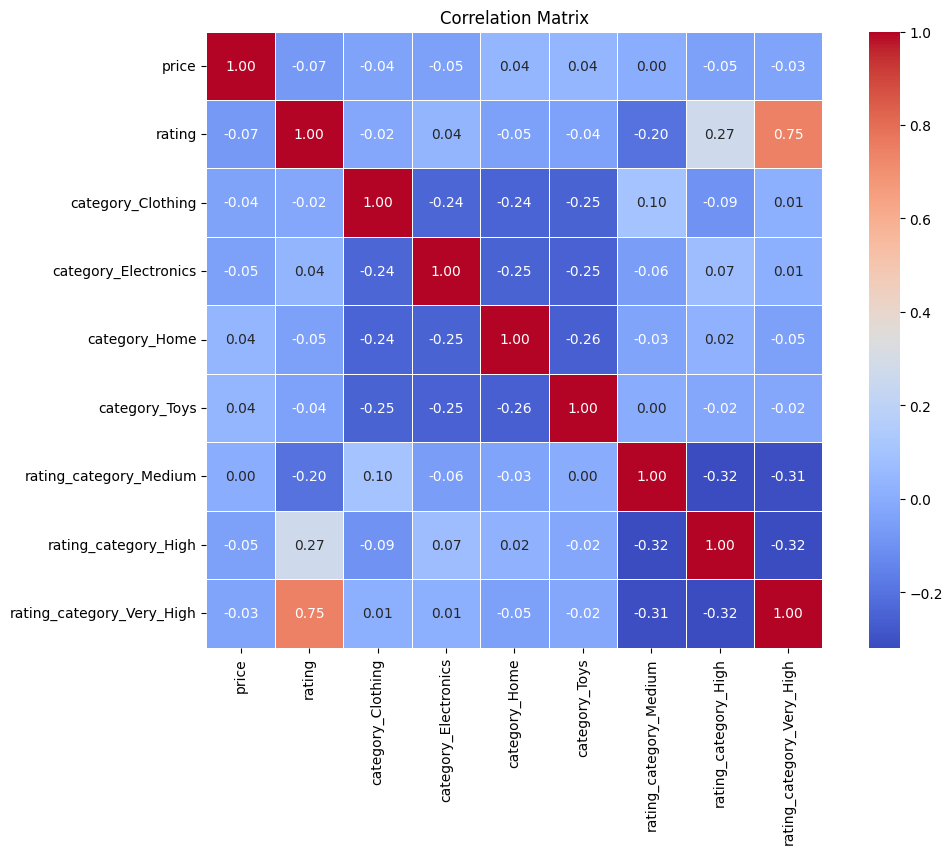

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the correlation matrix
correlation_matrix = X.corr()


# Set the size of the plot
plt.figure(figsize=(11, 6))

# Create a heatmap
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=0.5)

# Title and labels
plt.title('Correlation Matrix')
plt.show()

In [0]:
#Drop rating column due to a correlation of 0.75 between it and rating_category_Very_High column
X = X.drop(columns=['rating'])


- Due to a correlation of `0.75` between `rating` and `rating_category_Very_High`, the `rating` column was removed. This step ensures that each feature offers unique information, reducing the likelihood of multicollinearity impacting the logistic regression model.

- No Multicollinearity: `True`

- Linearity of Independent Variables: `Not Needed`

For logistic regression, we do not need a linear relationship between independent variables and the dependent variable.

####5. Preparing the data

**1. Checking if the target variable is imbalanced**
- Ensuring the model does not bias towards the majority class.

In [0]:
y.value_counts(normalize= True)

1    0.504514
0    0.495486
Name: in_demand, dtype: float64

- The data is balanced there is no need to `stratify`

**2. Train-Test Split**
- Splitting the data into training set and testing set (`20%` of the data)

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


**3. Standardization**

- Price: Being an integer value (e.g., dollars), prices can range widely depending on the product, and they may have high variability (from $1 to $1000+).

- Rating: This is a float value that typically ranges from 1 to 5. The scale is much narrower compared to price.

In [0]:
from sklearn.preprocessing import StandardScaler

#Z-Score Normalization
scaler = StandardScaler()

# Fit the scaler on the training data
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test data
X_test_scaled = scaler.transform(X_test)

###6. Fitting the Logistic Regression Model

In [0]:
from sklearn.linear_model import LogisticRegression

# Initialize the model
logistic_model = LogisticRegression()

# Fit the model on the standardized training data
logistic_model.fit(X_train_scaled, y_train)


Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

LogisticRegression()

####7. Making Predictions

In [0]:
# Predict class labels
y_pred = logistic_model.predict(X_test_scaled)

# Predict probabilities
y_pred_proba = logistic_model.predict_proba(X_test_scaled)[:, 1]  # Probability of class 1


####8. Evaluating the Model 

In [0]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

# Classification Report
class_report = classification_report(y_test, y_pred)
print("Classification Report:\n", class_report)

# ROC AUC Score
roc_auc = roc_auc_score(y_test, y_pred_proba)
print("ROC AUC Score:", roc_auc)

Confusion Matrix:
 [[ 89   0]
 [  4 107]]
Classification Report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98        89
           1       1.00      0.96      0.98       111

    accuracy                           0.98       200
   macro avg       0.98      0.98      0.98       200
weighted avg       0.98      0.98      0.98       200

ROC AUC Score: 0.9957485575463103


####9. Visualizing the Results

**1. ROC Curve**

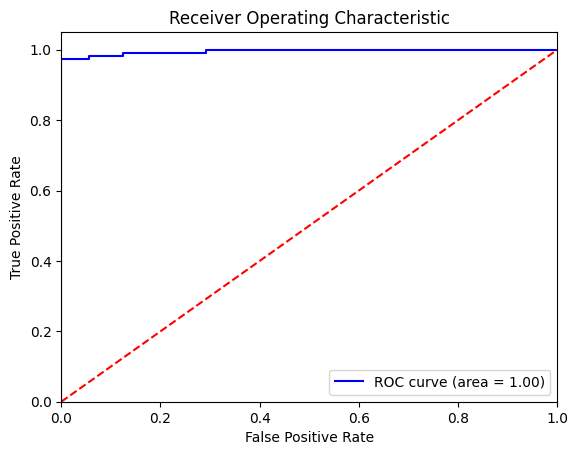

In [0]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='blue', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


**2. Confusion Matrix**

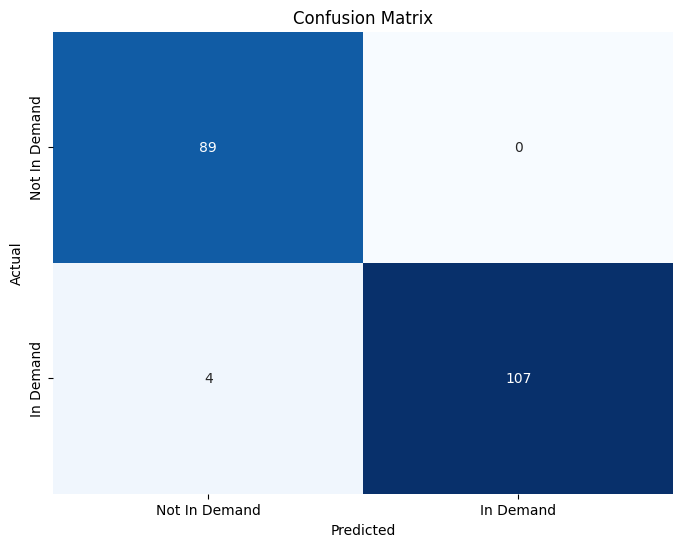

In [0]:
from sklearn.metrics import confusion_matrix

# Assuming y_test and y_pred are already defined
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a DataFrame for better visualization
cm_df = pd.DataFrame(cm, index=['Not In Demand', 'In Demand'], columns=['Not In Demand', 'In Demand'])

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

####10. Interpretting the Results

In [0]:
# Coefficients
coefficients = pd.DataFrame(logistic_model.coef_, columns=X.columns, index=['Coefficient'])
coefficients


,price,category_Clothing,category_Electronics,category_Home,category_Toys,rating_category_Medium,rating_category_High,rating_category_Very_High
Coefficient,0.019344,-0.04378,-0.040935,-0.424593,-0.387173,0.776089,3.864157,3.793168


#### interpretation of Logistic Regression Coefficients and Odds Ratios

The following coefficients represent the relationship between each feature and the likelihood of a product being classified as "in demand" (i.e., having a rating of 3 or above):

- **Price (0.019344)**: 
  - For each additional dollar increase in price, the log-odds of a product being classified as "in demand" increases by approximately `0.0193`.
  - **Odds Ratio**: 
  $$
  e^{0.019344} \approx 1.0195
  $$
  - This indicates that for every dollar increase in price, the odds of the product being classified as "in demand" increase by about `1.95%`.

- **Category_Clothing (-0.04378)**: 
  - Being in the Clothing category slightly reduces the log-odds of being "in demand" by `0.0438`.
  - **Odds Ratio**: 
  $$
  e^{-0.04378} \approx 0.957
  $$
  - This suggests that products in the Clothing category have about `4.3%` lower odds of being classified as "in demand" compared to the baseline category.

- **Category_Electronics (-0.040935)**: 
  - Being in the Electronics category has a slight negative effect on the log-odds of being "in demand," with a change of `0.041`.
  - **Odds Ratio**: 
  $$
  e^{-0.040935} \approx 0.960
  $$
  - This indicates that products in the Electronics category have about `4%` lower odds of being "in demand."

- **Category_Home (-0.424593)**: 
  - The Home category shows a negative effect on demand classification, reducing the log-odds by `0.425`.
  - **Odds Ratio**: 
  $$
  e^{-0.424593} \approx 0.654
  $$
  - Products in the Home category have approximately `34.6%` lower odds of being classified as "in demand."

- **Category_Toys (-0.387173)**: 
  - The Toys category also negatively affects the demand classification, decreasing the log-odds by `0.387`.
  - **Odds Ratio**: 
  $$
  e^{-0.387173} \approx 0.679
  $$
  - Products in the Toys category have about `32.1%` lower odds of being classified as "in demand."

- **Rating_Category_Medium (0.776089)**: 
  - Being in the medium rating category increases the log-odds of a product being "in demand" by `0.776`.
  - **Odds Ratio**: 
  $$
  e^{0.776089} \approx 2.173
  $$
  - Medium-rated products are approximately `2.17` times more likely to be classified as "in demand" compared to the baseline low rating category.

- **Rating_Category_High (3.864157)**: 
  - Being in the high rating category significantly boosts the log-odds of being "in demand" by `3.864`.
  - **Odds Ratio**: 
  $$
  e^{3.864157} \approx 47.6
  $$
  - High-rated products are around `47.6` times more likely to be classified as "in demand" compared to low-rated products.

- **Rating_Category_Very_High (3.793168)**: 
  - The Very High rating category also shows a strong positive relationship, increasing the log-odds of being "in demand" by `3.793`.
  - **Odds Ratio**: 
  $$
  e^{3.793168} \approx 44.40
  $$
  - Products in the Very High rating category are approximately `44.40` times more likely to be classified as "in demand" compared to the low rating category.

#### Confusion Matrix Interpretation

The confusion matrix results are as follows:

- **True Positives (TP)**: `107`
  - This indicates that `107` instances were correctly predicted as "in demand" (i.e., they were actually rated `3` or above).

- **False Positives (FP)**: `0`
  - There were no instances incorrectly predicted as "in demand," meaning that none of the products predicted to be in demand actually had a rating below `3`.

- **True Negatives (TN)**: `89`
  - This indicates that `89` instances were correctly predicted as not being "in demand" (i.e., they had ratings below `3`).

- **False Negatives (FN)**: `4`
  - This means that `4` instances that were actually "in demand" were incorrectly predicted as not being in demand.

### Summary of Performance Metrics

Based on these values, we can calculate the following performance metrics:

- **Accuracy**:
  $$
  \text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN} = \frac{107 + 89}{107 + 89 + 0 + 4} = \frac{196}{200} = 0.98
  $$
  The model has an accuracy of 98%, indicating that it correctly classified 98% of the instances.

- **Precision**:
  $$
  \text{Precision} = \frac{TP}{TP + FP} = \frac{107}{107 + 0} = 1.0
  $$
  The model has a precision of 100%, meaning that all products predicted as "in demand" were indeed in demand.

- **Recall**:
  $$
  \text{Recall} = \frac{TP}{TP + FN} = \frac{107}{107 + 4} = \frac{107}{111} \approx 0.964
  $$
  The model has a recall of approximately 96.4%, indicating that it correctly identified 96.4% of the actual "in demand" products.

- **F1 Score**:
  $$
  \text{F1 Score} = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}} = 2 \cdot \frac{1.0 \cdot 0.964}{1.0 + 0.964} \approx 0.981
  $$
  The F1 Score is approximately 98.1%, providing a strong balance between precision and recall.


### Conclusion

This analysis of the catalog data has yielded valuable insights into the factors influencing product demand within our e-commerce platform. The logistic regression model highlighted that various features significantly impact the likelihood of a product being classified as "in demand." 

Overall, the coefficients and their corresponding odds ratios provide insight into how different factors influence demand. Notably, higher product ratings have a substantial positive impact, increasing the likelihood of demand significantly. Conversely, certain categories may negatively influence demand, emphasizing the need for strategic management of these factors.

The performance of the logistic regression model was exceptional, as indicated by the confusion matrix metrics. With an accuracy of 98%, along with perfect precision and a recall rate of approximately 96.4%, the model demonstrates a high level of reliability in predicting which products are likely to be in demand. The absence of false positives further underscores the model’s effectiveness, allowing stakeholders to make informed decisions based on these insights.

In conclusion, by focusing on improving product ratings, and managing category performance, the company can enhance its product offerings and drive business growth in a competitive e-commerce landscape.


### Key Insights

1. **Significant Role of Ratings**:
   - Product ratings are the most influential factor in determining demand. Specifically, a one-point increase in the rating category ( moving from Low to Medium or Medium to High) increases the log-odds of being classified as "in demand" by approximately 3.8 times (for Very High ratings). This underscores the importance of focusing on customer satisfaction and quality control to enhance ratings.

2. **Pricing Impact**:
   - A one standard deviation increase in product price results in a `1.95%` increase in the log-odds of a product being classified as "in demand." This highlights the importance of effective pricing strategies, which must be thoughtfully managed to avoid discouraging potential buyers.

3. **Category-Specific Trends**:

   - The negative coefficients for all categories indicate that these categories perform worse in terms of demand compared to the Books category. This suggests that products categorized as Books are more appealing or have better market performance in driving demand than the other categories analyzed.

   - Products in the **Electronics** category have a slightly negative effect on demand, whereas categories such as **Clothing**, **Home**, and **Toys** negatively impact demand. This indicates a need for targeted category management strategies to enhance the performance of underperforming categories.

4. **High Precision and Reliability of the Model**:
   - The logistic regression model achieved an accuracy of 98%, with a precision of 100% and a recall of approximately 96.4%. This reflects the model's robustness in predicting product demand, allowing for confident decision-making based on its insights.

5. **Actionable Insights for Marketing and Product Strategy**:
   - To optimize marketing and product strategy, businesses should enhance product quality and customer satisfaction to improve ratings, particularly targeting Very High ratings that significantly boost demand. Reevaluating pricing strategies is essential to stay competitive and avoid deterring potential buyers. Additionally, targeted marketing efforts should be developed for underperforming categories like Clothing, Home, and Toys, leveraging predictive insights from models to inform inventory management and maximize demand.

6. **Continuous Monitoring Required**:
   - The model's findings suggest a dynamic market environment; thus, continuous monitoring of product performance and customer feedback is essential. Regular updates to marketing strategies will help maintain competitiveness and responsiveness to consumer preferences.

These key insights provide a comprehensive understanding of the factors influencing product demand and serve as a foundation for strategic decision-making.


### Summary for Stakeholders

Our analysis of the catalog data using logistic regression has revealed important insights regarding the factors influencing product demand:

- **Price**: For each standard deviation increase in the standardized price, the odds of a product being classified as "in demand" increase by approximately **1.95%** (odds ratio of **1.019**). This indicates a slight positive relationship, suggesting that pricing strategies should be carefully considered to avoid negatively impacting demand.

- **Category Effects**:
  - **Books**:
  Since the "Books" category is the baseline (with an implicit coefficient of 0), it represents the reference point for comparison with the other categories. Products in the Books category are considered to have the standard likelihood of being classified as "in demand."
  
  - **Clothing**: Products in the Clothing category have about **4.3%** lower odds of being classified as "in demand" (odds ratio of **0.957**). This finding indicates a need for improved product offerings or targeted marketing strategies to boost performance in this category.
  - **Electronics**: Products in the Electronics category exhibit about **4%** lower odds of being classified as "in demand" (odds ratio of **0.960**). Targeted marketing efforts could help enhance demand for these products.
  - **Home**: Products in the Home category have approximately **34.6%** lower odds of being classified as "in demand" (odds ratio of **0.654**). This substantial negative effect warrants immediate attention and strategic intervention to improve performance.
  - **Toys**: The odds for products in the Toys category are about **32.1%** lower (odds ratio of **0.679**), indicating the need for further investigation and strategy refinement to address demand challenges.

- **Rating Categories**:
  - **Medium Rating**: Products rated as Medium are approximately **2.17 times** more likely to be classified as "in demand" compared to low-rated products (odds ratio of **2.173**). This underscores the importance of maintaining competitive quality.
  - **High Rating**: Products with High ratings are around **47.6 times** more likely to be classified as "in demand" (odds ratio of **47.6**), emphasizing the critical role of customer satisfaction and quality control.
  - **Very High Rating**: Products in the Very High rating category are approximately **44.40 times** more likely to be classified as "in demand" (odds ratio of **44.40**), indicating that high-quality offerings strongly influence customer preferences.

### Recommendations

1. **Pricing Strategy**:
   - Given the positive relationship between standardized price and demand odds (1.019), consider implementing incremental pricing strategies that maximize revenue while being mindful of customer perception and demand.

2. **Category Management**:

   - **Focus on Books**: Given that Books are more likely to be in demand, it may be beneficial to promote this category further or      expand the product offerings within it.

   - **Clothing and Electronics**: Conduct thorough market research to understand consumer preferences and enhance product offerings or marketing efforts in these categories. Consider targeted promotions to stimulate demand.
   - **Home and Toys**: Due to their significantly lower odds (0.654 and 0.679, respectively), reassess product assortments in these categories. Explore customer feedback to identify areas for improvement and potential product introductions.

3. **Enhance Product Ratings**:
   - Implement quality control measures to boost product ratings. Encourage customers to provide feedback and reviews, particularly for high-impact categories. Consider loyalty incentives for positive customer engagement.

4. **Targeted Marketing**:
   - Develop marketing campaigns that focus on high-rated products, especially in the High and Very High rating categories, to leverage their strong influence on demand.

5. **Ongoing Monitoring**:
   - Continuously monitor product performance and customer feedback to adapt strategies proactively. Regularly update pricing and marketing tactics based on real-time insights and market dynamics.

By implementing these recommendations, the company can effectively enhance product demand, improve customer satisfaction, and drive overall business growth.
